In [1]:
import pandas as pd
import glob
import torch, os
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast, TrainingArguments, Trainer, DistilBertForSequenceClassification, DistilBertTokenizerFast
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as TorchDataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [2]:
!pip install transformers[torch]

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 

In [3]:
!pip install accelerate -U

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU')
else:
    device = torch.device("cpu")
    print('CPU')

GPU


In [5]:
train_paths = ['/content/train/california_wildfires_2018_train.tsv',
               '/content/train/canada_wildfires_2016_train.tsv',
               '/content/train/cyclone_idai_2019_train.tsv',
               '/content/train/ecuador_earthquake_2016_train.tsv',
               '/content/train/greece_wildfires_2018_train.tsv',
               '/content/train/hurricane_dorian_2019_train.tsv',
               '/content/train/hurricane_florence_2018_train.tsv',
               '/content/train/hurricane_harvey_2017_train.tsv',
               '/content/train/hurricane_irma_2017_train.tsv',
               '/content/train/hurricane_maria_2017_train.tsv',
               '/content/train/hurricane_matthew_2016_train.tsv',
               '/content/train/italy_earthquake_aug_2016_train.tsv',
               '/content/train/kaikoura_earthquake_2016_train.tsv',
               '/content/train/kerala_floods_2018_train.tsv',
               '/content/train/maryland_floods_2018_train.tsv',
               '/content/train/midwestern_us_floods_2019_train.tsv',
               '/content/train/pakistan_earthquake_2019_train.tsv',
               '/content/train/puebla_mexico_earthquake_2017_train.tsv',
               '/content/train/srilanka_floods_2017_train.tsv']

val_paths = ['/content/dev/california_wildfires_2018_dev.tsv',
             '/content/dev/canada_wildfires_2016_dev.tsv',
             '/content/dev/cyclone_idai_2019_dev.tsv',
             '/content/dev/ecuador_earthquake_2016_dev.tsv',
             '/content/dev/greece_wildfires_2018_dev.tsv',
             '/content/dev/hurricane_dorian_2019_dev.tsv',
             '/content/dev/hurricane_florence_2018_dev.tsv',
             '/content/dev/hurricane_harvey_2017_dev.tsv',
             '/content/dev/hurricane_irma_2017_dev.tsv',
             '/content/dev/hurricane_maria_2017_dev.tsv',
             '/content/dev/hurricane_matthew_2016_dev.tsv',
             '/content/dev/italy_earthquake_aug_2016_dev.tsv',
             '/content/dev/kaikoura_earthquake_2016_dev.tsv',
             '/content/dev/kerala_floods_2018_dev.tsv',
             '/content/dev/maryland_floods_2018_dev.tsv',
             '/content/dev/midwestern_us_floods_2019_dev.tsv',
             '/content/dev/pakistan_earthquake_2019_dev.tsv',
             '/content/dev/puebla_mexico_earthquake_2017_dev.tsv',
             '/content/dev/srilanka_floods_2017_dev.tsv']

test_paths = ['/content/test/california_wildfires_2018_test.tsv',
              '/content/test/canada_wildfires_2016_test.tsv',
              '/content/test/cyclone_idai_2019_test.tsv',
              '/content/test/ecuador_earthquake_2016_test.tsv',
              '/content/test/greece_wildfires_2018_test.tsv',
              '/content/test/hurricane_dorian_2019_test.tsv',
              '/content/test/hurricane_florence_2018_test.tsv',
              '/content/test/hurricane_harvey_2017_test.tsv',
              '/content/test/hurricane_irma_2017_test.tsv',
              '/content/test/hurricane_maria_2017_test.tsv',
              '/content/test/hurricane_matthew_2016_test.tsv',
              '/content/test/italy_earthquake_aug_2016_test.tsv',
              '/content/test/kaikoura_earthquake_2016_test.tsv',
              '/content/test/kerala_floods_2018_test.tsv',
              '/content/test/maryland_floods_2018_test.tsv',
              '/content/test/midwestern_us_floods_2019_test.tsv',
              '/content/test/pakistan_earthquake_2019_test.tsv',
              '/content/test/puebla_mexico_earthquake_2017_test.tsv',
              '/content/test/srilanka_floods_2017_test.tsv']

train_file_paths = []

for path in train_paths:
    files = glob.glob(path)
    train_file_paths.extend(files)

val_file_paths = []

for path in val_paths:
    files = glob.glob(path)
    val_file_paths.extend(files)

test_file_paths = []

for path in test_paths:
    files = glob.glob(path)
    test_file_paths.extend(files)

In [6]:
train_dfs = []

for file in train_file_paths:
    df = pd.read_csv(file, sep='\t')
    df = df.iloc[:, 1:] # removing tweet ids
    df = df[df['class_label'] != 'missing_or_found_people']
    train_dfs.append(df)

train_df = pd.concat(train_dfs, ignore_index=True)

val_dfs = [] # dataframes

for file in val_file_paths:
    df = pd.read_csv(file, sep='\t')
    df = df.iloc[:, 1:] # removing tweet ids
    df = df[df['class_label'] != 'missing_or_found_people']
    val_dfs.append(df)

val_df = pd.concat(val_dfs, ignore_index=True)

test_dfs = [] # dataframes

for file in test_file_paths:
    df = pd.read_csv(file, sep='\t')
    df = df.iloc[:, 1:] # removing tweet ids
    df = df[df['class_label'] != 'missing_or_found_people']
    test_dfs.append(df)

test_df = pd.concat(test_dfs, ignore_index=True)

ValueError: No objects to concatenate

In [ ]:
class_labels = train_df['class_label'].unique().tolist()
class_counts = train_df['class_label'].value_counts()
min_class_size = class_counts.min()  # Size of the smallest class

balanced_dfs = []  # List to hold balanced DataFrames for each class
for class_label in class_labels:
    class_df = train_df[train_df['class_label'] == class_label]
    sampled_df = class_df.sample(n=min_class_size, random_state=42)  # Randomly sample to match smallest class size
    balanced_dfs.append(sampled_df)

train_df = pd.concat(balanced_dfs, ignore_index=True)
# Optional: Shuffle the balanced DataFrame
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

class_labels = [s.strip() for s in class_labels]

In [ ]:
id2label = {id:label for id, label in enumerate(class_labels)}
label2id = {label:id for id, label in enumerate(class_labels)}

In [ ]:
all_labels = pd.concat([train_df['class_label'], val_df['class_label'], test_df['class_label']]).unique()

# Create a mapping from class labels to numbers
label_to_num = {label: num for num, label in enumerate(all_labels)}

# Step 2: Apply this mapping to each dataset
train_df['class_label_num'] = train_df['class_label'].map(label_to_num)
val_df['class_label_num'] = val_df['class_label'].map(label_to_num)
test_df['class_label_num'] = test_df['class_label'].map(label_to_num)

In [ ]:
train_df.class_label.value_counts().plot(kind='pie', figsize=(10,10))

In [ ]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizerFast.from_pretrained(model_name)

In [ ]:
train_tweets = list(train_df.tweet_text)
train_labels = list(train_df.class_label_num)

val_tweets = list(val_df.tweet_text)
val_labels = list(val_df.class_label_num)

test_tweets = list(test_df.tweet_text)
test_labels = list(test_df.class_label_num)

In [ ]:
train_encodings = tokenizer(train_tweets, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_tweets, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_tweets, truncation=True, padding=True, max_length=512)

In [ ]:
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)


In [ ]:
train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)
test_dataset = TweetDataset(test_encodings, test_labels)

In [ ]:
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(label_to_num))
model.to(device)

In [ ]:
training_args = TrainingArguments(
    output_dir='/content/bert_model_output',
    do_train=True,
    do_eval=True,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    fp16=True,
    warmup_steps=200,
    weight_decay=0.01,
    logging_strategy='steps',
    logging_dir='/content/logs',
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=500,
    load_best_model_at_end=True,
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
# Train the model
trainer.train()

In [ ]:
trainer.evaluate(eval_dataset=test_dataset)

In [7]:
train_path = "/content/train/crisis_consolidated_humanitarian_filtered_lang_train.tsv"

val_path = "/content/dev/crisis_consolidated_humanitarian_filtered_lang_dev.tsv"
test_path = "/content/test/crisis_consolidated_humanitarian_filtered_lang_test.tsv"


In [8]:
train_df = pd.read_csv(train_path, sep='\t')
train_df = train_df[['text', 'class_label']]

val_df = pd.read_csv(val_path, sep='\t')
val_df = val_df[['text', 'class_label']]

test_df = pd.read_csv(test_path, sep='\t')
test_df = test_df[['text', 'class_label']]

<Axes: ylabel='count'>

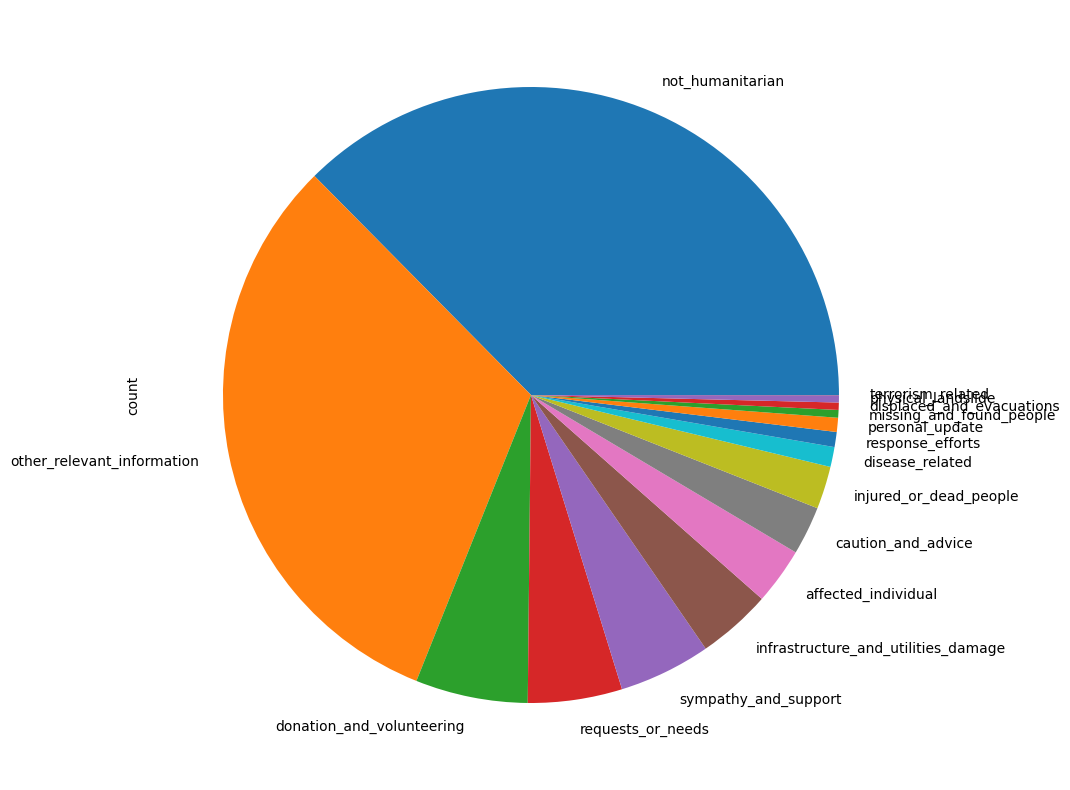

In [9]:
train_df.class_label.value_counts().plot(kind='pie', figsize=(10,10))

In [10]:
class_labels = train_df['class_label'].unique().tolist()
class_counts = train_df['class_label'].value_counts()
class_counts

class_label
not_humanitarian                       37031
other_relevant_information             31207
donation_and_volunteering               5839
requests_or_needs                       4893
sympathy_and_support                    4776
infrastructure_and_utilities_damage     3846
affected_individual                     2946
caution_and_advice                      2521
injured_or_dead_people                  2215
disease_related                         1035
response_efforts                         780
personal_update                          732
missing_and_found_people                 400
displaced_and_evacuations                380
physical_landslide                       376
terrorism_related                         11
Name: count, dtype: int64

<Axes: ylabel='count'>

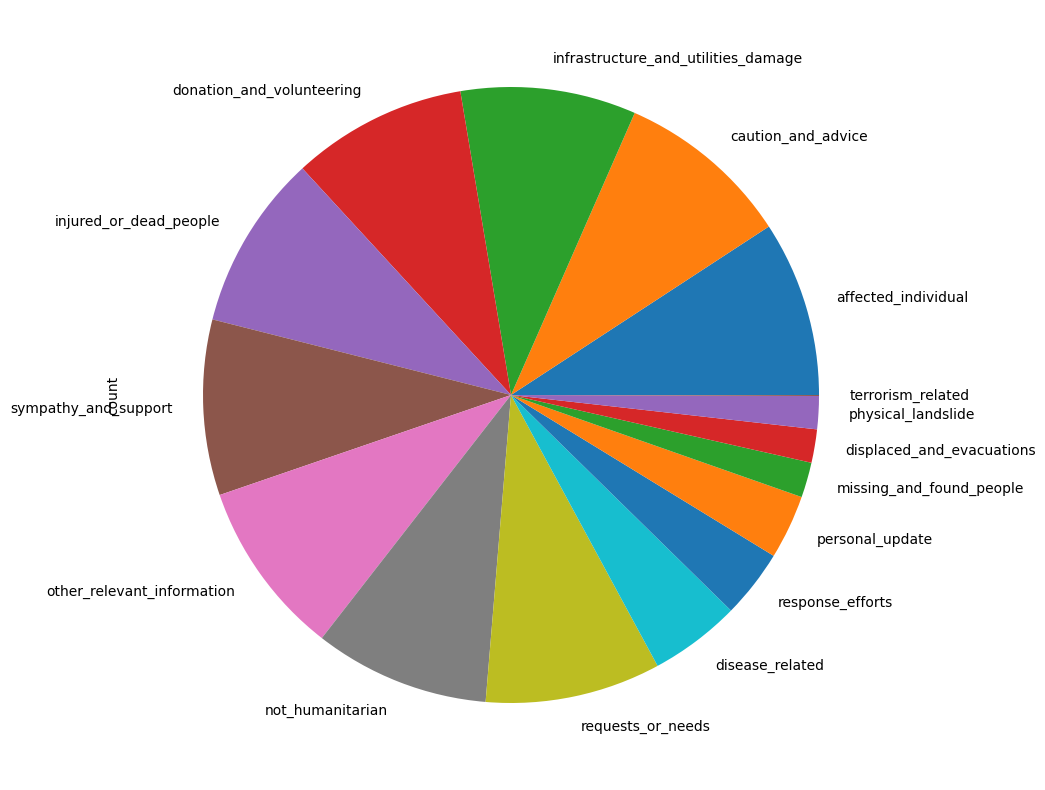

In [11]:
# classes are imbalanced and too much samples, so we will use a subset of the data

# limit samples to 2000 per class, take random 2000 if class has more than 2000 samples
train_df = train_df.reset_index(drop=True)
train_df = train_df.groupby('class_label').apply(lambda x: x.sample(n=2000, random_state=42) if len(x) > 2000 else x)
train_df.class_label.value_counts().plot(kind='pie', figsize=(10,10))

<Axes: ylabel='count'>

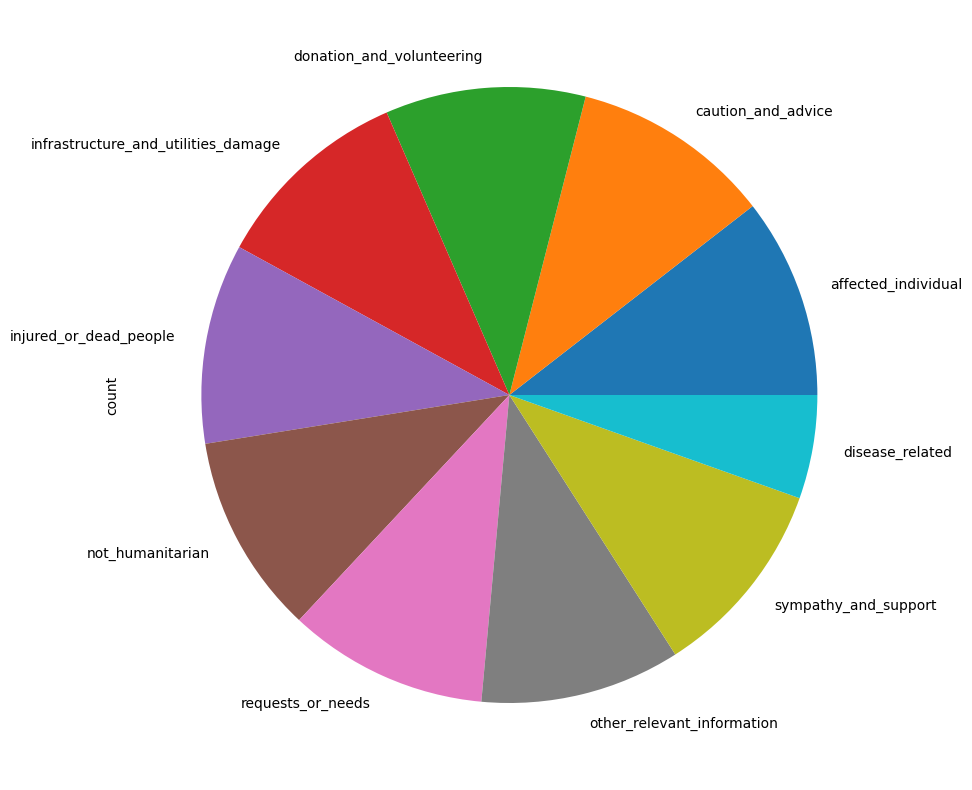

In [12]:
# delete classes that have below 1000 samples
# remove class_label from previous groupby
train_df = train_df.reset_index(drop=True)
train_df = train_df.groupby('class_label').filter(lambda x: len(x) > 1000)
train_df.class_label.value_counts().plot(kind='pie', figsize=(10,10))

In [13]:
class_labels = train_df['class_label'].unique().tolist()
class_counts = train_df['class_label'].value_counts()
class_counts

class_label
affected_individual                    2000
caution_and_advice                     2000
donation_and_volunteering              2000
infrastructure_and_utilities_damage    2000
injured_or_dead_people                 2000
not_humanitarian                       2000
requests_or_needs                      2000
other_relevant_information             2000
sympathy_and_support                   2000
disease_related                        1035
Name: count, dtype: int64

In [14]:
id2label = {id:label for id, label in enumerate(class_labels)}
label2id = {label:id for id, label in enumerate(class_labels)}

In [15]:
# Encoding the labels
all_labels = pd.concat([train_df['class_label'], val_df['class_label'], test_df['class_label']]).unique()

label_to_num = {label: num for num, label in enumerate(all_labels)}

train_df['class_label_num'] = train_df['class_label'].map(label_to_num)
val_df['class_label_num'] = val_df['class_label'].map(label_to_num)
test_df['class_label_num'] = test_df['class_label'].map(label_to_num)

In [16]:
#additional preprocessing, remove https links
import re
def remove_links(text):
    return re.sub(r'http\S+', '', text)

train_df['text'] = train_df['text'].apply(remove_links)
val_df['text'] = val_df['text'].apply(remove_links)
test_df['text'] = test_df['text'].apply(remove_links)

In [17]:
train_tweets = list(train_df.text)
train_labels = list(train_df.class_label_num)

val_tweets = list(val_df.text)
val_labels = list(val_df.class_label_num)

test_tweets = list(test_df.text)
test_labels = list(test_df.class_label_num)

In [18]:
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizerFast.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [19]:
train_encodings = tokenizer(train_tweets, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_tweets, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_tweets, truncation=True, padding=True, max_length=512)

In [20]:
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

In [21]:
train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)
test_dataset = TweetDataset(test_encodings, test_labels)

In [22]:
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(label_to_num))
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
!pip install transformers[torch]

In [ ]:
!pip install accelerate -U

In [23]:
training_args = TrainingArguments(
    output_dir='/content/bert_model_output',
    do_train=True,
    do_eval=True,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    fp16=True,
    warmup_steps=200,
    weight_decay=0.01,
    logging_strategy='steps',
    logging_dir='/content/logs',
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=500,
    load_best_model_at_end=True,
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [24]:
# Train the model
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,2.522600,2.061950,0.383400,0.331443,0.454088,0.383400
200,1.623200,1.717700,0.407371,0.401399,0.565201,0.407371


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KeyboardInterrupt: 